# Unit root test and Hurst exponent

<img src="media/cover.png" style="width: 40%; display: block; margin: auto;">

## Overview

- We will first recap and provide more details about some concepts we saw in the previous lectures.
- Then, we will introduce new analytics tools and some of their application in financial applications.

- The content of the lecture is organized as follows:
    1. Small recap.
    2. Unit root test.
    3. Mean reversion.
    4. Hurst Exponent.
    5. Geometric Brownian motion.

In [2]:
# Imports
import warnings
warnings.simplefilter(action="ignore", category=(FutureWarning, DeprecationWarning))
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
np.random.seed(0)  # For reproducible results

---

## Small recap

- We've covered lots of material in the previous lessons. 
- Now is a good time to step back and rehash what we've covered.

### Decomposition

- Time series data can be decomposed into trend, seasonal, and random fluctuation components.

**Trends**
- Increasing.
- Decreasing.
- Flat.
- Larger trends can be made up of smaller trends.
- There is no defined timeframe for what constitutes a trend: it depends on your data and task at hand.

**Seasonal effects**
- Weekend retail sales spikes.
- Holiday shopping.
- Energy requirement changes with annual weather patterns.

**Random Fluctuations**
- The human element.
- Aggregations of small influencers.
- Observation errors.
- The smaller this is in relation to trend and seasonal components, the better we can predict the future.

### Additive vs Multiplicative

- Two simple categories of time series models:

**Additive**
- Data = Trend + Seasonal + Random.
- If our seasonality and fluctuations are stable, we likely have an additive model.

**Multiplicative**
- Data = Trend $\times$ Seasonal $\times$ Random.
- As easy to fit as Additive if we take the log: ``log(Data) = log(Trend + Seasonal + Random)``.
- Use multiplicative models if:
  - the amplitude in seasonal and random fluctuations grows with the trend,
  - the percentage change of our data is more important than the absolute value change (e.g. stocks, commodities).

### Stationarity

A time series is stationary if:

- The mean of the series is constant.
- The variance does not change over time (homoscedasticity).
- The covariance is not a function of time.

<img src="media/non-stationarity.png" style="width: 60%; display: block; margin: auto;">

### Detect non-stationarity

- Make a run-sequence plot.

- Rolling statistics:
  - Compute and plot rolling statistics such as moving average/variance on chunks of data.
  - Check if the statistics change over time. 
  - This technique can be done on different windows (small windows are noisy, large windows too conservative).

- Augmented Dickey-Fuller (ADF) test:
    - Statistical tests for checking stationarity. 
    - The null hypothesis $H_0$ is that the time series is non-stationary. 
    - If the test statistic is small enough and the $p$-value below the target $\alpha$, we _can_ reject $H_0$ and say that the series is stationary.

### Achieve stationarity

- Take the log of the data.
- Difference (multiple times if needed) to remove trends and seasonality.
- Subtract estimated trend and seasonal components.

## Unit root test

- The ADF is one of the most popular unit root tests.
- The presence of a unit root suggests that the time series is generated by a stochastic process with some level of persistence.
- This means that shocks to the system will have permanent effects. 
- This is opposed to stationary processes where shocks have only temporary effects.

> Where does the term *unit root* comes from?

- Consider a simple autoregressive process of order 1, denoted as AR(1). 
- This is represented as: 

$$Y(t) = \phi Y(t-1) + \epsilon_t,$$

- where 
    - $Y(t)$ is the value of the series at time $t$, 
    - $\phi$ is a coefficient, 
    - $\epsilon_t$ is a white noise error term.

- To analyze the properties of the AR(1), we can rewrite its equation in terms of **lag operator** $L$ where $LY(t) = Y(t-1)$. 
- The equation becomes: 

$$(1 - \phi L)Y(t) = \epsilon_t$$

- The term $(1 - \phi L)$ is known as the **characteristic equation** of the AR(1) process.

- The roots of this equation are found by setting $1 - \phi L = 0$ and solving for $L$. 
- The solution gives $L = 1/\phi$, which is the **root of the characteristic equation**.

- If $\phi = 1$, then $L = 1/\phi = 1$, meaning that the root of the characteristic equation has a "unit" value. 
- This is what is known as a "unit root". 
- When an AR(1) process has a unit root (i.e., $\phi = 1$), it implies that the series is non-stationary as it becomes a random walk: $Y(t) = Y(t-1) + \epsilon_t$ 
- The value of the series will be highly dependent on its previous values (the shocks to the series have a permanent effect).

> In conclusion, the term "unit root" describes a specific condition in the autoregressive representation of a time series, indicating that the series is **non-stationary**. 

### More on the ADF test 

**Formulation of the test**
- The basic idea of the ADF test is to assess whether lagged values of the time series are useful in predicting current values. 
- The test starts with a model that includes the time series lagged by one period (lag-1).
- Then, other lagged terms are added to control for higher-order correlation (this is the "augmented" part of the ADF test).

**ADF test equation**

The ADF test model the time series with the following equation:

$$\Delta Y(t) = \alpha + \beta t + \gamma Y(t-1) + \sum_{i=1}^{p} \delta_i \Delta_{t-i} + \epsilon_t$$

- where
    - $\Delta_t = Y(t) - Y(t-1)$ is the difference of the series at time $t$,
    - $\alpha$ is a constant, 
    - $\beta$ represents the trend, 
    - $\gamma$ is the coefficient on the lagged value of the series,
    - $\delta_i$ terms are coefficients for the lagged differences (account for higher-order correlations),
    - $\epsilon_t$ error term.

**ADF test for AR(1)**

- Where does the model used in the ADF test come from?
- Consider the simple case of an AR(1) model:

$$
    Y(t) = \phi Y(t-1) + \epsilon_t
$$

- Subtract $Y(t-1)$ from both sides:

\begin{align*}
    Y(t) - Y(t-1) & = \phi Y(t-1) - Y(t-1) + \epsilon_t \\
    \Delta Y(t) &= (\phi - 1) Y(t-1) + \epsilon_t
\end{align*}

This is exactly the ADF model above when:
- $p=1$
- $\alpha=\beta=0$ (zero-mean and no trend)
- $\gamma = \phi - 1$

**Connection to unit root**

- If $\gamma = 0$, then $\phi = 1$ (unit root).
- This means that 

$$\Delta Y(t) = \epsilon_t \implies Y(t) = Y(t-1) + \epsilon_t,$$ 

- which is the non-stationary random walk.

**Null and alternative hypotheses (revised)**
- $H_0$: $\gamma = 0$ the time series has unit root, i.e., it is not stationary.
- $H_1$: $\gamma < 0$ the series does not have a unit root.

**Test statistics**:
- The ADF test statistic is the coefficient $\hat{\gamma}$, estimated from data.
- The estimated statistic $\hat{\gamma}$ is then compared to critical values for the ADF distribution.
- If the test statistic is more negative than the critical value, $H_0$ is rejected.
- If the test statistic is less negative than the critical value, $H_0$ cannot be rejected.

- For example, consider a confidence level $\alpha=0.05$.
- According to the distribution of $\gamma$, it correspond to a critical value of $\gamma_\alpha=-2.89$.
- If the test statistic $\hat\gamma$ is more negative than the critical value $\gamma_\alpha$, $H_0$ is rejected.
- If the test statistic $\hat\gamma$ is less negative than the critical value $\gamma_\alpha$, $H_0$ cannot be rejected.

**Choosing lag length**:
- The number of lags ($p$) included in the test equation is important. 
- Too few lags might leave out necessary corrections for autocorrelation.
- Too many lags can reduce the power of the test.
- The appropriate lag length is often chosen based on information criteria such as the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC).

In [3]:
# Generating a random walk time series
data = pd.Series(100 + np.random.normal(0, 1, 100).cumsum())

# Perform Augmented Dickey-Fuller test. The lag can be set manually 
# with 'maxlag' or inferred automatically with autolag
result = adfuller(data, autolag='AIC')  # You can change to 'BIC'

adf_statistic, p_value, usedlag, nobs, critical_values, icbest = result
print(f'ADF Statistic: {adf_statistic :.2f}')
print(f'p-value: {p_value :.2f}')
print(f'Used Lag: {usedlag}')
print(f'Number of Observations: {nobs}')
print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(critical_values.values(), critical_values.keys())]}\n")

ADF Statistic: -1.13
p-value: 0.70
Used Lag: 0
Number of Observations: 99
Critical Values: ['1%: -3.50', '5%: -2.89', '10%: -2.58']



**Types of ADF tests**
- There are three versions of the ADF test depending on whether the equation includes the constant term $\alpha$ and the trend $\beta t$:
     - No constant or trend (`'n'`).
     - Constant, but no trend (`'c'`).
     - Both constant and trend (`'ct'`).
- The choice among these depends on the nature of the underlying time series and on what we want to test.

In [4]:
# Function to perform ADF test
def perform_adf_test(series, title, regression_type):
    out = adfuller(series, regression=regression_type)
    print(f"Results for {title}:")
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")

# 1. No Constant, no Trend
series_no_const_no_trend = pd.Series(np.random.normal(0, 1, 200))

# 2. Constant, but no Trend
series_const_no_trend = pd.Series(50 + np.random.normal(0, 1, 200))

# 3. Both Constant and Trend
series_const_trend = pd.Series(50 + np.linspace(0, 20, 200) + np.random.normal(0, 1, 200))

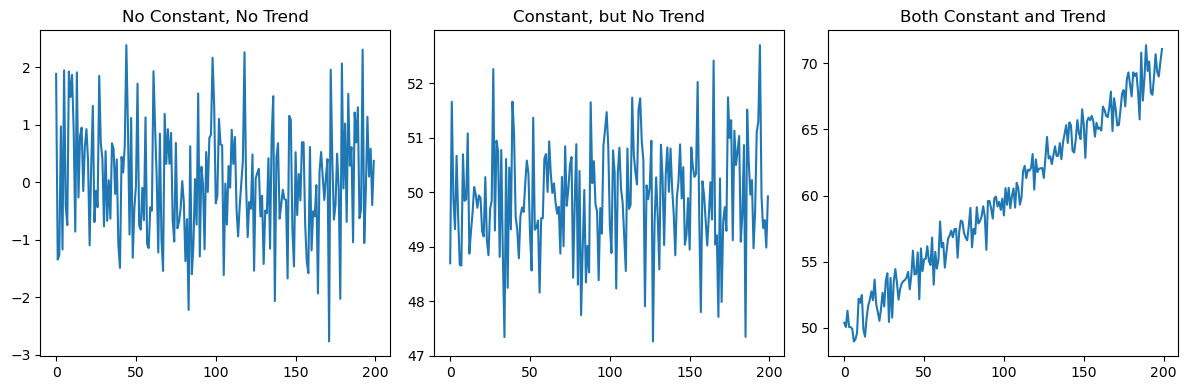

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
series_no_const_no_trend.plot(title='No Constant, No Trend')
plt.subplot(1, 3, 2)
series_const_no_trend.plot(title='Constant, but No Trend')
plt.subplot(1, 3, 3)
series_const_trend.plot(title='Both Constant and Trend')
plt.tight_layout();

In [6]:
# 1. No Constant or Trend
perform_adf_test(series_no_const_no_trend, "No Constant, No Trend", 'n')

# 2. Constant, but No Trend
perform_adf_test(series_const_no_trend, "Constant, No Trend", 'c')

# 3. Both Constant and Trend
perform_adf_test(series_const_trend, "Constant and Trend", 'ct')

Results for No Constant, No Trend:
ADF Statistic: -15.47
p-value: 0.000
Critical Values: ['1%: -2.58', '5%: -1.94', '10%: -1.62']

Results for Constant, No Trend:
ADF Statistic: -13.95
p-value: 0.000
Critical Values: ['1%: -3.46', '5%: -2.88', '10%: -2.57']

Results for Constant and Trend:
ADF Statistic: -14.68
p-value: 0.000
Critical Values: ['1%: -4.00', '5%: -3.43', '10%: -3.14']



- In the last two cases, without accounting for the non-zero mean and the trend we would not reject $H_0$.
- Try using ``'n'`` in the last two examples and see for yourself.

---

## Mean reversion test

- Mean reversion refers to the property of a time series to revert to its historical mean. 
- This concept is particularly popular in financial economics, where it is often assumed that asset prices and revert to their historical average over the long term.
- There is no proper mathematical definition of mean reversion.

### Applications in finance

1. **Portfolio Management** 
    - Investors use mean reversion as a strategy to buy assets that have underperformed and sell assets that have overperformed, expecting that they will revert to their historical mean.

2. **Risk Management** 
    - Understanding mean reversion helps in assessing the long-term risk of assets. 
    - If an asset is highly mean-reverting, it might be considered less risky over the long term, as it tends to move back to its average.

3. **Economic Forecasting** 
    - Economic variables (like GDP growth rates, interest rates) often exhibit mean-reverting behavior. 
    - This assumption is used in macroeconomic models and forecasts.

### Testing for mean reversion
- Determines whether, after a deviation from its mean, a time series will eventually revert back to that mean. 
- This can be done using unit root tests such as ADF.
- If a time series has a unit root, it implies that it does not revert to a mean.
- The absence of a unit root can be indicative of mean reversion.

**Example: Google stocks**

We will download the Google Open-High-Low-Close-Volume (GOOG OHLCV) data from the 1st September 2004 to 31st August 2020 from [Yahoo finance](https://finance.yahoo.com/) using the ``yfinance`` Python package.

In [7]:
def get_data(tickerSymbol, period, start, end):

    # Get data on the ticker
    tickerData = yf.Ticker(tickerSymbol)

    # Get the historical prices for this ticker
    tickerDf = tickerData.history(period=period, start=start, end=end)
    
    return tickerDf
    
data = get_data('GOOG', period='1d', start='2004-09-01', end='2020-08-31')

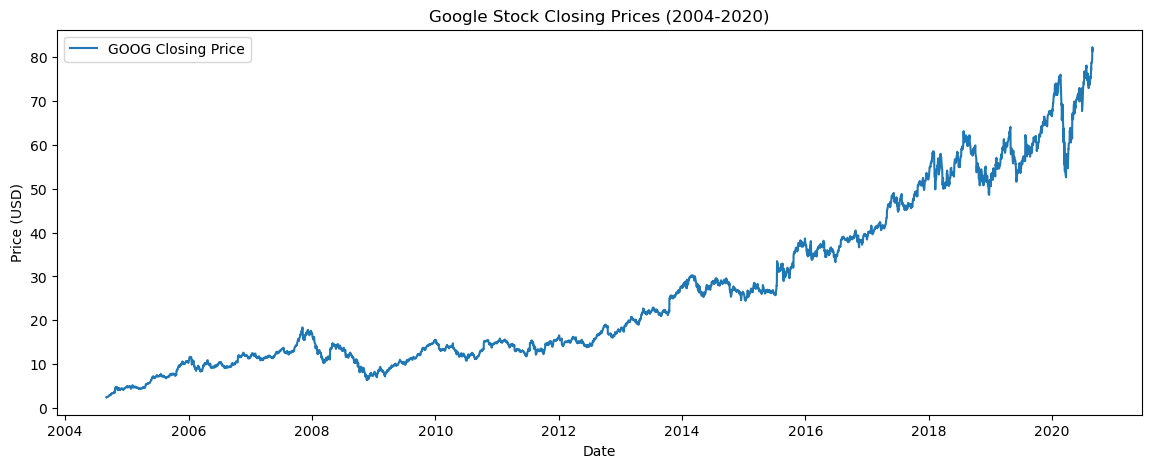

In [8]:
# Plotting the Closing Prices
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='GOOG Closing Price')
plt.title('Google Stock Closing Prices (2004-2020)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend();

In [9]:
# Perform the ADF test
perform_adf_test(data['Close'],"Google Stock Closing Prices", 'ct')

Results for Google Stock Closing Prices:
ADF Statistic: -0.78
p-value: 0.968
Critical Values: ['1%: -3.96', '5%: -3.41', '10%: -3.13']



- We cannot reject $H_0$.
- It does not look like a mean reverting time series.

### Mean reversion VS stationarity

Testing for mean reversion and testing for stationarity are related but distinct concepts in time series analysis.

**Key Differences**:
- Mean reversion testing is focused on whether a time series will return to a specific level (the mean).
- Stationarity testing checks if the overall statistical properties of the series remain consistent over time.

**Key Differences (cont.)**:
- A stationary time series may or may not be mean reverting. 
    - A stationary series with a constant mean and variance over time might still not revert to its mean after a shock.
- Conversely, a mean-reverting series must have some stationarity, particularly in its mean, but or other properties (e.g., variance) might change over time.

## Hurst exponent

- The Hurst exponent ($H$) is a measure used to characterize the long-term memory of time series. 
- It helps to determine the presence of autocorrelation or persistence in the data. 
- The goal of the Hurst exponent is to provide us with a scalar value that will help us to identify whether a series is  
    - random walking,
    - trending,
    - mean reverting.

- The key insight is that, if any *autocorrelation* exists, then

$$\text{Var}(X(t + \tau) - X(t)) \propto \tau^{2H}$$

- where $H$ is the Hurst exponent.

A time series can then be characterised in the following manner:

- If $H = 0.5$, the time series is similar to a random walk. In this case, the variance increases *linearly* with $\tau$.
- If $H < 0.5$, the time series exhibits anti-persistence, i.e. mean reversal. The variance increases *less than linearly* with $\tau$.
- If $H > 0.5$, the time series exhibits persistent long-range dependence, i.e. is trending. The variance increases *more than linearly* with $\tau$.

In [10]:
def hurst(ts):
        
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.var(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    # Use a linear fit to estimate the Hurst exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]/2.0

**How do persistent and anti-persistent time series look like?**

- Let's create a Python script (adapted from [here](https://github.com/Mottl/hurst/tree/master)) to generate random walk with persistence.
- We must incorporate a form of "memory" by considering past values within a specified look-back window to decide the direction of the next step. 

Let's define

```python
def random_walk_memory(length, proba, min_lookback, max_lookback)
```

where:
- ``proba`` is the probability that the next increment will follow the trend.
    - proba > 0.5 persistent random walk
    - proba < 0.5 antipersistent one

- ``min_lookback`` and ``max_lookback`` are the minimum and maximum window sizes to calculate trend direction

In [11]:
def random_walk_memory(length, proba=0.5, min_lookback=1, max_lookback=100):
    series = [0.] * length  
    for i in range(1, length):
        
        # If the series has not yet reached the min_lookback threshold
        # the direction of the step is random (-1 or 1) 
        if i < min_lookback + 1:
            direction = np.sign(np.random.randn())
            
        # consider the historical values to determine the direction
        else:
            # randomly choose between min_lookback and the minimum of 
            # i-1 (to ensure not exceeding the current length) and max_lookback.
            lookback = np.random.randint(min_lookback, min(i-1, max_lookback)+1)
            
            # Decides whether to follow the recent trend or move against it, 
            # based on a comparison between proba and a random number between 0 and 1.
            recent_trend = np.sign(series[i-1] - series[i-1-lookback])
            change = np.sign(proba - np.random.uniform())
            direction = recent_trend * change
        
        series[i] = series[i-1] + np.fabs(np.random.randn()) * direction
    return series

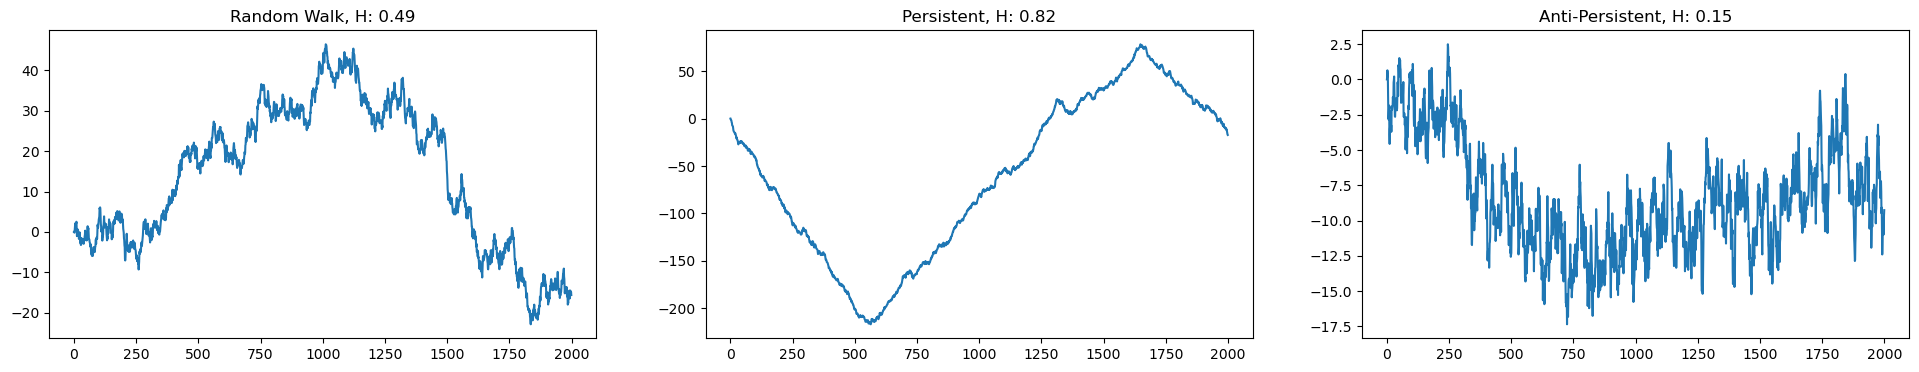

In [24]:
bm = random_walk_memory(2000, proba=0.5)
persistent = random_walk_memory(2000, proba=0.7)
antipersistent = random_walk_memory(2000, proba=0.3)

_, axes = plt.subplots(1,3, figsize=(24, 4))
axes[0].plot(bm)
axes[0].set_title(f"Random Walk, H: {hurst(bm):.2f}")
axes[1].plot(persistent)
axes[1].set_title(f"Persistent, H: {hurst(persistent):.2f}")
axes[2].plot(antipersistent)
axes[2].set_title(f"Anti-Persistent, H: {hurst(antipersistent):.2f}");

- What is the Hurst exponent of the Google stocks closing price?

In [13]:
print(f"GOOG closing price, H: {hurst(data['Close'].values):.2f}")

GOOG closing price, H: 0.41


- Google stocks' time series approaches $H=0.5$, indicating that it is close to a geometric random walk (at least for the sample period we're looking at).
- What does this mean in practice?

### Interpretation of the Hurst exponent in finance:

- The Hurst exponent, $H$, is a critical metric in the analysis of financial time series.
- Offers insights into the behavior of assets such as stocks. 
- Here's how to interpret $H$ in the context of *closing stock prices* and its influence on *investment decisions*.

**Case 1: $H = 0.5$**

- This value suggests that the stock price follows a random walk. 
- It implies that future price movements are independent of past movements. 
- For investors, this means that there are no autocorrelations in price movements to exploit; past data cannot predict future prices. 
- Trading strategies based on historical price patterns or trends are, theoretically, no more likely to be successful than random guessing.
- Investors should rely on broader market analysis or diversified portfolio strategies rather than trying to predict future prices based on past trends.

**Case 2: $H < 0.5$** 

- Indicates a mean-reverting series, i.e., the stock price tends to revert to its historical average. 
- This suggests that the asset is less risky over the long term. 
- Investors might interpret a low $H$ as an opportunity to buy stocks after a significant drop, expecting a reversion to the mean, or to sell after a substantial rise.

**Case 3: $H > 0.5$**

- Suggests a trending series, where increases or decreases in stock prices are likely to be followed by further increases or decreases, respectively. 
- This persistence indicates potential momentum in stock prices, which can be exploited by momentum strategies:
  - Buying stocks that have been going up in the hope that they will continue to do so, and selling those in a downtrend.


#### Practical considerations:

Before applying these interpretations, investors should also make the following considerations:
- The observed value of $H$ can vary over different time frames: analyze $H$ over the period relevant to the investment horizon.
- External factors such as market conditions, economic indicators, and geopolitical events can influence stock prices and should be considered alongside $H$.
- Regardless of the value of $H$, implementing proper risk management strategies is essential to protect against unexpected market movements.
- If the time series is too short, the value of $H$ might not be reliable.

---

## Brownian Motion 

- Recall the random walk 

$$X(t) = X(t-1) + \epsilon_t$$ 

- where $\epsilon_t \sim \mathcal{N}(0,\sigma^2)$.

- This can also be expressed as:

$$X(t) = X(0) + W(t)$$ 

- where $W(t)$ is called *Wiener Process*, or as:

$$X(t) = X(0) + B(t)$$ 

- where $B(t)$ is called *Brownian Motion*.
- $W(t)$ and $B(t)$ represents the cumulative sum of normally distributed increments $\epsilon_1 + \epsilon_2 + \dots \epsilon_t$.

**Variance of Brownian Motion at time lag $\tau$**

- For a time series $X(t)$, the variance at a time lag $\tau$ can be defined as: 

$$\text{Var}(X(t + \tau) - X(t))$$

- Given $B(t)$ as Brownian motion, the increment $B(t + \tau) - B(t)$ is normally distributed with mean 0 and variance $\tau$.
- This is because the variance of the increments of Brownian motion over a period $\tau$ is $\tau$. 

$$\text{Var}(B(t + \tau) - B(t)) = \tau$$

---

## Geometric Brownian Motion

- The *Geometric Brownian Motion* (GBM) is a stochastic process.
- Is is often used to model stock prices and other financial variables that do not revert to a mean but rather exhibit trends with a drift $\mu$ and volatility $\sigma$. 

The GBM is defined as: 

$$S(t) = S_0 \exp\left((\mu - \frac{1}{2} \sigma^2)t + \sigma W(t)\right)$$ 

- where
    - $S(t)$ is the stock price at time $t$.
    - $S_0$ is the initial stock price at time $t = 0$.
    - $\mu$ is the expected annual return (drift coefficient).
    - $\sigma$ is the volatility (standard deviation of returns).
    - $W(t)$ is a Wiener process (standard Brownian motion).

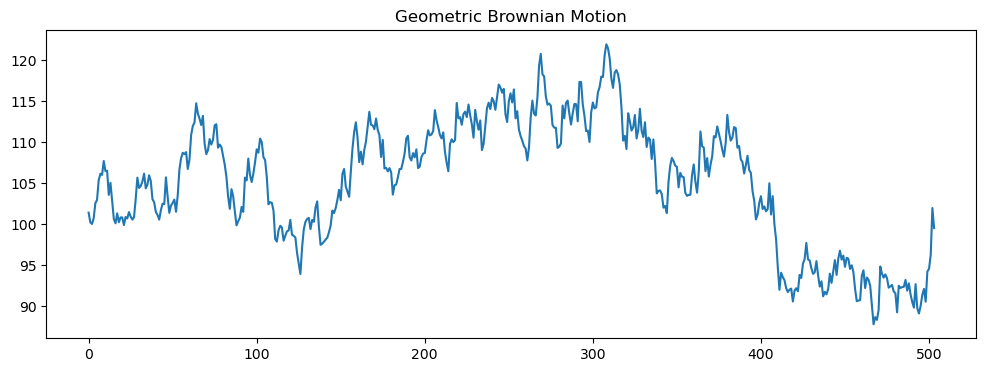

In [14]:
S0 = 100                 # Initial stock price
mu = 0.09                # Expected annual return (9%)
sigma = 0.25             # Annual volatility (25%)
T = 2                    # Time horizon in years
dt = 1/252               # Time step in years, assuming 252 trading days per year
N = int(T/dt)            # Number of time steps
t = np.linspace(0, T, N) # Time vector

# Brownian Motion
dW = np.random.normal(0, np.sqrt(dt), N)
W = np.cumsum(dW)

# Geometric Brownian Motion
S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

plt.figure(figsize=(12, 4))
plt.plot(S)
plt.title('Geometric Brownian Motion');

### Variance of GBM

- First, note that $S(t)$ is *log-normally distributed* because it's an exponential function of a normally distributed process $B(t)$. 
- The variance of $S(t)$ can be found from the properties of the log-normal distribution:

$$\text{Var}(S(t)) = \left(e^{\sigma^2 t} - 1\right) e^{2\mu t + \sigma^2 t} S_0^2.$$

- This shows that the variance of GBM is not linear in $t$ like the BM.
- Instead, it grows *exponentially* with time due to the exponential term $e^{\sigma^2 t}$.
- This, and the possibility of modelling drift (expected annual return) are the main additions of GBM over BM.

### Real world applications

- GBM can be used to model real stock prices and simulate their future behavior.
- First, we estimate $\mu$ and $\sigma$ from historical stock price data. 
    - $\mu$ could be the historical average of the stock's logarithmic returns.
    - $\sigma$ could be the standard deviation of those returns.
- Then, we use these estimates in the GBM formula to simulate future price paths.

- This method is widely used for option pricing, risk management, and investment strategy simulations. 
- However, GBM has limitations, such as assuming a *constant* drift ($\mu$) and volatility ($\sigma$).
- These assumptions may not hold true in real markets. 
- Therefore, it's often used as a component of a broader analysis or modeling strategy.

In [15]:
# Step 1: Get the "training" data (e.g., 2020-2022)
data2 = get_data('GOOG', period='1d', start='2019-12-31', end='2022-12-31')

In [16]:
# Get "test" data, for comparison (e.g., 2023)
data3 = get_data('GOOG', period='1d', start='2022-12-31', end='2023-12-31')
test_days = len(data3)

In [17]:
# Step 2: Calculate Daily Returns
returns = data2['Close'].pct_change() # We are interested in returns, so we get the changes in %

In [18]:
# Step 3: Estimate Parameters for GBM
mu = returns.mean() * 252  # Annualize the mean
sigma = returns.std() * np.sqrt(252)  # Annualize the std deviation

In [19]:
# Step 4: Set GBM parameters
T = 1  # Time horizon in years
dt = 1/test_days  # Time step in years, assuming 252 trading days per year
N = int(T/dt)  # Number of time steps
time_step = np.linspace(0, T, N)
S0 = data2['Close'].iloc[-1]  # Starting stock price (latest close price) 

In [25]:
#  Step 5: Compute Simulation
W = np.random.standard_normal(size=N)
W = np.cumsum(W)*np.sqrt(dt)  # Cumulative sum for the Wiener process
X = (mu - 0.5 * sigma**2) * time_step + sigma * W
S = S0 * np.exp(X)  # GBM formula

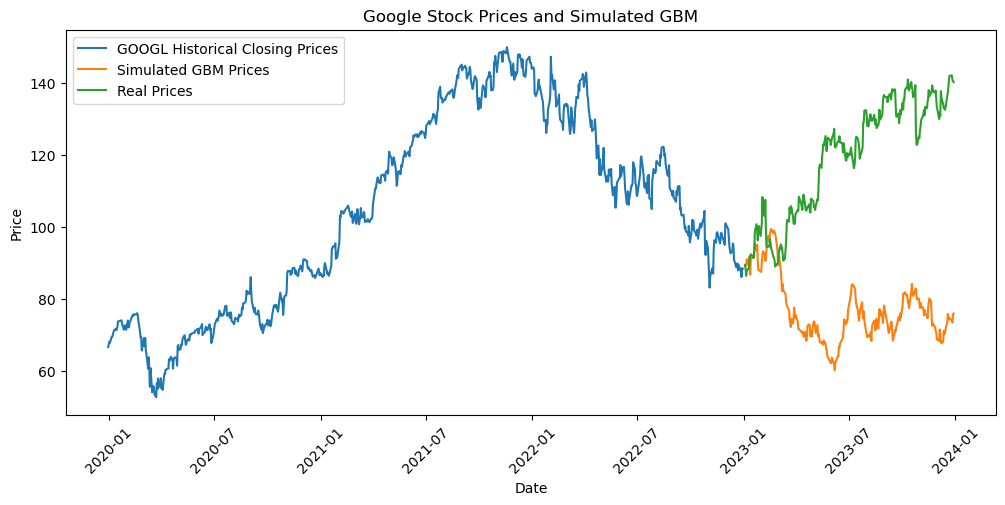

In [26]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(data2['Close'], label='GOOGL Historical Closing Prices')
plt.plot(data3.index, S, label='Simulated GBM Prices')
plt.plot(data3['Close'], label='Real Prices')
plt.legend()
plt.title('Google Stock Prices and Simulated GBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45);

- There is a stochastic component in each GBM realization..
- Usually, more paths are simulated to get a more informative simulation.

In [22]:
# Simulate multiple paths
n_paths = 10
paths = []
for _ in range(n_paths):
    W = np.cumsum(np.random.standard_normal(size=N))*np.sqrt(dt)
    X = (mu - 0.5 * sigma**2) * time_step + sigma * W
    paths.append(S0 * np.exp(X))
    
path_mean = np.array(paths).mean(axis=0)
path_std = np.array(paths).std(axis=0)

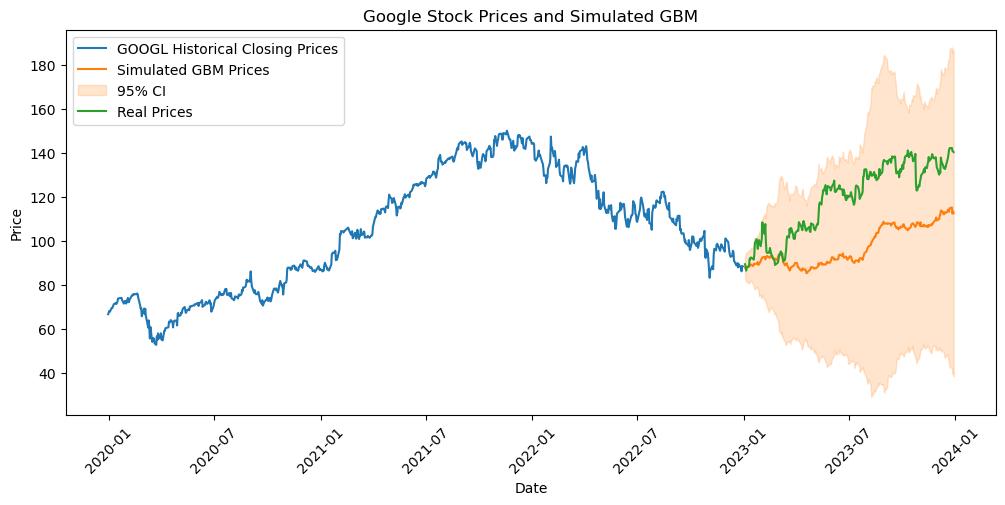

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(data2['Close'], label='GOOGL Historical Closing Prices')
plt.plot(data3.index, path_mean, label='Simulated GBM Prices')
plt.fill_between(data3.index, path_mean-1.96*path_std, path_mean+1.96*path_std, color='tab:orange', alpha=0.2, label='95% CI')
plt.plot(data3['Close'], label='Real Prices')
plt.legend(loc='upper left')
plt.title('Google Stock Prices and Simulated GBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45);

---

## Summary

In this lecture we covered:
1. Unit root test and a deeper insight on ADF test.
2. Mean Reversion and how to test it with ADF.
3. Hurst Exponent: how to compute it and its application in finance.
4. Geometric Brownian Motion: definition and application to simulate stocks.

---

## Exercise 

- Download and plot the historical closing prices of Tesla (``TSLA``) and Equinor (``EQNR``) for the years ``2019-12-31``- ``2022-12-31``.
- For each time series:
    - Test if the time series look stationary.
    - Compute the Hurst coefficient for both time series.
    - Which stock would you like to invest into? Motivate your answer based on the tests and the value of $H$.
    - Simulate the stock prices using GBM.

- Which simulation seems to be more reliable? The one for Tesla or Equinor? 
- To motivate your answer: 
    1. compute the simulation at least 100 times.
    2. Compute the MSE between the true stock prices and the simulated ones.
    3. Compare the expected value of the MAPE for the two stocks.